In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_data_dir = 'dataset/train'
validation_data_dir = 'dataset/valid'
test_data_dir = 'dataset/test'

# ImageDataGenerator for data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training data
train = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),  # Resize images to match InceptionV3 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_test_datagen = ImageDataGenerator(rescale=1 / 255.0)

# Load validation data
validation = valid_test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299, 299), # Resize images to match InceptionV3 input size
    batch_size=32,
    class_mode='categorical'
)

# Load test data
test = valid_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(299, 299), # Resize images to match InceptionV3 input size
    batch_size=32,
    class_mode='categorical'
)

Found 7634 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = Dropout(0.3)(x) #Regularizers => I added this because the validate accuracy didn't increase after epochs
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(53, activation='softmax')(x)  # Output layer for 53 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning the layers of InceptionV3
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [4]:
# fix duplicate library error
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [5]:
callbacks = [EarlyStopping(monitor='loss', patience=3), History()]
history = model.fit(
        train,
        steps_per_epoch=len(train),
        epochs=200,
        validation_data=validation,
        validation_steps=len(validation), callbacks=callbacks
    )

Epoch 1/200
239/239 [==============================] - 1651s 7s/step - loss: 2.8015 - accuracy: 0.1819 - val_loss: 64.0258 - val_accuracy: 0.0453
Epoch 2/200
239/239 [==============================] - 247s 1s/step - loss: 1.9041 - accuracy: 0.3775 - val_loss: 2.0423 - val_accuracy: 0.4000
Epoch 3/200
239/239 [==============================] - 249s 1s/step - loss: 1.5165 - accuracy: 0.5244 - val_loss: 2.9296 - val_accuracy: 0.4943
Epoch 4/200
239/239 [==============================] - 254s 1s/step - loss: 1.2652 - accuracy: 0.6090 - val_loss: 0.7286 - val_accuracy: 0.7774
Epoch 5/200
239/239 [==============================] - 251s 1s/step - loss: 1.0699 - accuracy: 0.6637 - val_loss: 0.6029 - val_accuracy: 0.7849
Epoch 6/200
239/239 [==============================] - 244s 1s/step - loss: 0.9124 - accuracy: 0.7205 - val_loss: 0.5155 - val_accuracy: 0.8528
Epoch 7/200
239/239 [==============================] - 247s 1s/step - loss: 0.8407 - accuracy: 0.7486 - val_loss: 0.3064 - val_accurac

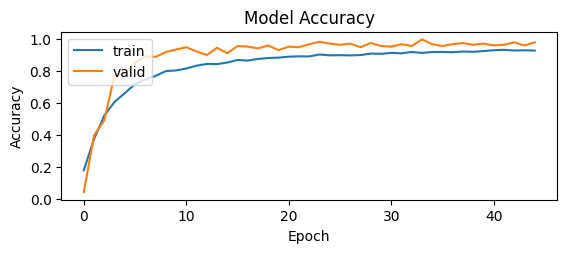

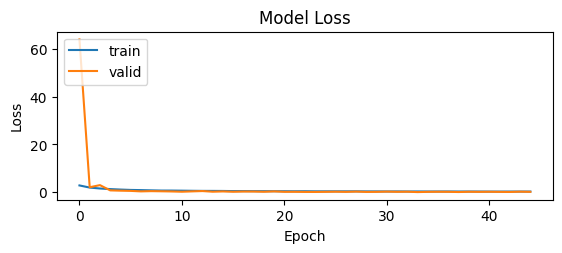

In [6]:
from matplotlib import pyplot as plt
# Plot accuracy
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Plot loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [7]:
model.save("model.keras")

In [71]:
import tensorflow as tf

model = tf.keras.models.load_model('model.keras')

predictions = model.predict(test)

OSError: Unable to open file (file signature not found)

In [9]:
pred_classes = predictions.argmax(axis=-1)

print(pred_classes)
print(test.labels)


[12 24  0 25 28 41 30 31  5 21 15 27 48 49 28 29 46  0 33 23 12 14 24 18
 36 30 29 34 48 24 21 50  3  1 13 31 35 15 44  7  2 27 40 19 29 51 26  6
 34 16 46 33 31  5 18 32 13  2  9 47 23 24 30 26 25 27  3  5 11 17 32 45
 44 11  3 24 18 26 20  0 39 48 36 39 37 22 49  1 44  1 35 25  1 34 22 40
 35 50 47 52 42 16  9 17 44 50 39 43 45 47 25 11 14 17  2 19 10 46 22 23
 21 26 27 47  4 48 48  1 25 16 32  5 14 38 11 50 15 36 50 46 49 16  0  6
  4 45 52 52 21  9 37  7 20 37 10 26  8 12 49 23  3 10 17 31 28 14 20 43
 34  8 35 38 43 27 12  4 13 18 14 25 23 30 42 40 41 43 32 47  8 33 39 22
 29 28 29 38 36  4 51 33  6 10  7 19 44 51 18 16  2  0 29 51 10 38 20  7
 31 22 42 37 38  3 41 21  5 13 45 11 49 24 15  7 45 45 44 19 34  7 32  6
 35  9 30  8 41 40  9 46 13 40  5 20 39 43 51 52 19 42  6 36  2 41  4  8
 17]
[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 

In [10]:
import numpy as np

def get_confusion_matrix(label, predictions, number_of_classes):
    confusion_matrix = np.zeros((number_of_classes, number_of_classes), dtype=int)

    for idx in range(len(label)):
        confusion_matrix[label[idx]][predictions[idx]] += 1

    return confusion_matrix

In [11]:
confusion_matrix = get_confusion_matrix(test.labels, pred_classes, 53)

np.savetxt('confusion_matrix.txt', confusion_matrix, fmt='%i')

In [12]:
def counts_from_confusion(confusion):
    """
    Obtain TP, FN FP, and TN for each class in the confusion matrix
    """

    counts_list = []

    # Iterate through classes and store the counts
    for i in range(confusion.shape[0]):
        tp = confusion[i, i]

        fn_mask = np.zeros(confusion.shape)
        fn_mask[i, :] = 1
        fn_mask[i, i] = 0
        fn = np.sum(np.multiply(confusion, fn_mask))

        fp_mask = np.zeros(confusion.shape)
        fp_mask[:, i] = 1
        fp_mask[i, i] = 0
        fp = np.sum(np.multiply(confusion, fp_mask))

        tn_mask = 1 - (fn_mask + fp_mask)
        tn_mask[i, i] = 0
        tn = np.sum(np.multiply(confusion, tn_mask))

        counts_list.append({'Class': i,
                            'TP': tp,
                            'FN': fn,
                            'FP': fp,
                            'TN': tn})

    return counts_list

In [13]:
count_confusion = counts_from_confusion(confusion_matrix)

with open(r'count_confusion.txt', 'w') as fp:
    for cls in count_confusion:
        fp.write("%s\n" % cls)
    print('Done')

Done
